# Only the mathematical trading strategy for getting the signals

In [31]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Dataset

In [32]:
df_3m = pd.read_csv('datasets/btc_5m.csv')
df_3m['datetime'] = pd.to_datetime(df_3m['datetime'])
df_3m.set_index('datetime', inplace=True)
df_3m

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
2018-01-01 05:35:00,13600.00,13600.00,13501.01,13554.58,40.528679
2018-01-01 05:40:00,13554.58,13569.97,13400.01,13556.15,49.469536
2018-01-01 05:45:00,13533.75,13547.73,13402.00,13430.52,32.725614
2018-01-01 05:50:00,13440.01,13459.99,13410.44,13439.94,26.614135
...,...,...,...,...,...
2022-01-31 05:10:00,37950.55,37979.31,37875.58,37959.87,119.164080
2022-01-31 05:15:00,37959.87,37959.88,37876.94,37896.41,73.051970
2022-01-31 05:20:00,37896.41,37948.79,37870.00,37928.03,41.395230


In [33]:
def filter_df(df, start_date, end_date):
    subset_df = df.loc[start_date:end_date]
    return subset_df

start_date = '2018-01-01'
end_date = '2019-01-01'
filtetred_df_3m = filter_df(df_3m, start_date, end_date)
print(filtetred_df_3m.shape)
filtetred_df_3m.iloc[[0,-1],:]

(104549, 5)


,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13576.28,13600.00,33.617798
2019-01-01 23:55:00,3677.98,3680.33,3675.25,3675.26,34.812100


In [34]:
def plot_candlestick_chart(df,num_candles=-1):
    if num_candles != -1:
        df = df.iloc[:num_candles]
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

    # Customize the layout
    fig.update_layout(title='Candlestick chart',
                    xaxis_title='Date and Time',
                    yaxis_title='Price data',
                    xaxis_rangeslider_visible=False)

    # Show the plot
    fig.show()

In [35]:
# plot_candlestick_chart(df_3m,num_candles=500)

## Strategy

### Adding the indicators

In [36]:
def add_indicators(df):
    # SMA
    df['SMA_14'] = df['close'].rolling(window=14).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    
    # RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    short_window = 12
    long_window = 26
    signal_window = 9

    exp_short = df['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = df['close'].ewm(span=long_window, adjust=False).mean()

    df['MACD'] = exp_short - exp_long
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    # Bollinger Bands
    window = 20
    df['Upper_Band'] = df['SMA_20'] + 2 * df['close'].rolling(window=window).std()
    df['Lower_Band'] = df['SMA_20'] - 2 * df['close'].rolling(window=window).std()

    # ATR
    # Calculate True Range (TR)
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Choose the ATR period (e.g., 14 days)
    atr_period = 14

    # Calculate ATR using rolling mean
    df['ATR'] = df['TrueRange'].rolling(window=atr_period).mean()

    # Drop intermediate columns used for calculation
    df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'TrueRange'], axis=1, inplace=True)

    # Removing null rows
    df = df.dropna()
    return df

In [37]:
test_df = add_indicators(filtetred_df_3m)
print(test_df.shape)
test_df

(104500, 14)


C:\Users\sanya\AppData\Local\Temp\ipykernel_24936\3146903090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_14'] = df['close'].rolling(window=14).mean()
C:\Users\sanya\AppData\Local\Temp\ipykernel_24936\3146903090.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_20'] = df['close'].rolling(window=20).mean()
C:\Users\sanya\AppData\Local\Temp\ipykernel_24936\3146903090.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,open,high,low,close,volume,SMA_14,SMA_20,SMA_50,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR
datetime,,,,,,,,,,,,,,
2018-01-01 09:35:00,13447.73,13455.05,13370.00,13400.00,20.443116,13451.181429,13408.2405,13432.2132,55.229492,10.114115,10.256253,13601.782820,13214.698180,89.285000
2018-01-01 09:40:00,13399.99,13427.48,13322.15,13351.71,32.528288,13455.374286,13411.4260,13427.2474,54.324571,2.606398,8.726282,13598.628936,13224.223064,90.952143
2018-01-01 09:45:00,13354.99,13389.98,13323.55,13330.05,36.474570,13453.949286,13416.9285,13422.7568,48.449522,-5.033283,5.974369,13586.035163,13247.821837,89.983571
2018-01-01 09:50:00,13336.98,13410.00,13331.00,13408.99,17.610242,13451.377857,13421.3240,13419.8136,47.130560,-4.664220,3.846651,13584.403398,13258.244602,88.265000
2018-01-01 09:55:00,13408.99,13449.89,13391.31,13430.00,16.478325,13449.372857,13424.5245,13419.8032,47.790564,-2.645904,2.548140,13585.530734,13263.518266,85.666429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 23:35:00,3682.84,3684.28,3670.16,3675.26,62.013564,3688.100000,3689.5250,3690.9834,34.476902,-2.686393,-1.507334,3701.149248,3677.900752,7.412143
2019-01-01 23:40:00,3675.02,3676.90,3670.37,3670.47,43.618202,3686.666429,3688.4000,3690.3828,33.459700,-3.691898,-1.944247,3702.673622,3674.126378,7.580000
2019-01-01 23:45:00,3670.86,3680.10,3670.00,3674.51,55.077349,3685.422857,3687.4125,3689.6644,36.254540,-4.115334,-2.378464,3702.677436,3672.147564,8.114286


<Figure size 1400x600 with 0 Axes>

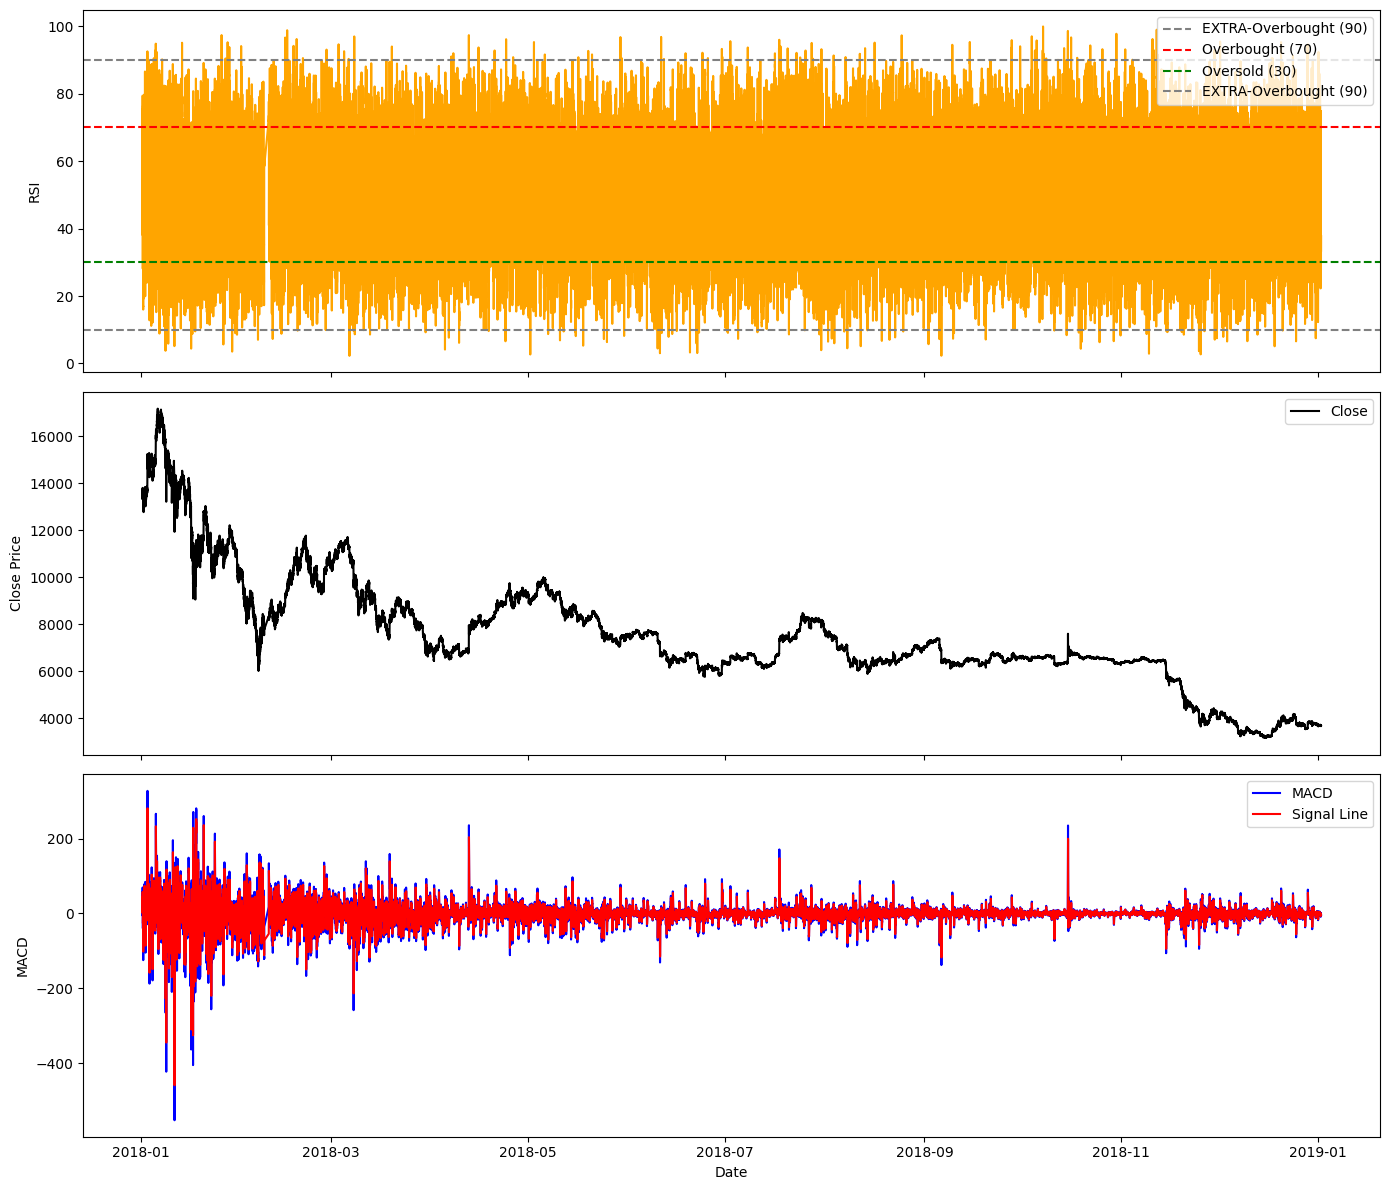

In [38]:
# For understanding the indicators

plot_df = test_df.iloc[:,:]
plt.figure(figsize=(14, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 12), sharex=True)

# Plotting RSI
axes[0].plot(plot_df.index, plot_df['RSI'], color='orange')
axes[0].axhline(90, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].axhline(70, color='r', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='g', linestyle='--', label='Oversold (30)')
axes[0].axhline(10, color='grey', linestyle='--', label='EXTRA-Overbought (90)')
axes[0].legend()
axes[0].set_ylabel('RSI')

# Plotting Close values and SMAs
axes[1].plot(plot_df.index, plot_df['close'], label='Close', color='black')
# axes[1].plot(plot_df['SMA_14'],label="14 previous average")
# axes[1].plot(plot_df['SMA_20'],label="20 previous average")
axes[1].legend()
axes[1].set_ylabel('Close Price')

# Plotting MACD and Signal Line
axes[2].plot(plot_df.index, plot_df['MACD'], label='MACD', color='blue')
axes[2].plot(plot_df.index, plot_df['Signal_Line'], label='Signal Line', color='red')
axes[2].legend()
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# plot_candlestick_chart(plot_df)

In [39]:
# States
usd = 10000
btc = 0

# Define trading parameters
atr_factor = 1.5
take_profit_factor = 2
stop_loss = 0
target = 0
initial_close = test_df.loc[test_df.index[0],'close']
prev_resistance, resistance = initial_close,initial_close
prev_support, support = initial_close,initial_close

# Initialize columns for signals and balances
test_df.loc[:,'Signal'] = ''
test_df.loc[:,'Balance_USD'] = None
test_df.loc[:,'Balance_BTC'] = None

C:\Users\sanya\AppData\Local\Temp\ipykernel_24936\639996591.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Signal'] = ''
C:\Users\sanya\AppData\Local\Temp\ipykernel_24936\639996591.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Balance_USD'] = None
C:\Users\sanya\AppData\Local\Temp\ipykernel_24936\639996591.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [40]:
# Signals
def buy(usd, btc, current_close):
    if usd > 0 and btc == 0:
        btc = (usd - (usd * .0015)) / current_close
        usd = 0
        return usd, btc, 'Buy'
    else:
        return usd, btc, "Holding"

def sell(usd, btc, current_close):
    if btc > 0 and usd == 0:
        usd = (btc - (btc * .0015)) * current_close
        btc = 0
        return usd, btc, 'Sell'
    else:
        return usd, btc, 'Waiting'

In [41]:
# Dataframe updation
def update_df(i,usd, btc, signal):
    test_df.at[test_df.index[i], 'Signal'] = signal
    test_df.at[test_df.index[i], 'Balance_USD'] = usd
    test_df.at[test_df.index[i], 'Balance_BTC'] = btc

In [43]:
# Trading loop
for i in range(0, len(test_df)):
    # print(i)
    signal = ''
    indications = {
        "MACD-signal_line":0,
        # "RSI":0,
        # "candlestick":0,
    }

    current_row = test_df.iloc[i]
    # Check for general trend of the trade
    if current_row['MACD'] > current_row['Signal_Line']:
        indications['MACD-signal_line'] = 1 # Positive indication
    elif current_row['MACD'] < current_row['Signal_Line']:
        indications['MACD-signal_line'] = -1 # Negative indication
        # print(f"{i} MACD:{current_row['MACD']}\tSignal_Line:{current_row['Signal_Line']}")
    else:
        indications['MACD-signal_line'] = 0 # Neutral indication

    # Decide the signal
    vote = max(set(indications.values()), key=list(indications.values()).count)
    if vote == 1: # If enough things indicate upwards, if have sell, buy
        usd, btc, signal = buy(usd, btc, current_row['close'])
        update_df(i, usd, btc, signal)
        continue
    if vote == -1:# If enough things indicate downwards, and own btc, sell
        usd, btc, signal = sell(usd, btc, current_row['close'])
        update_df(i, usd, btc, signal)
        continue
    else: # Else just wait for the next turn
        signal = "Wait" if usd > 0  else "Hold"
        update_df(i, usd, btc, signal)
        continue
    # print(f"{vote}\t{signal}")
    # Update the progress
    # update_df(i, usd, btc, signal, indications)

test_df

,open,high,low,close,volume,SMA_14,SMA_20,SMA_50,RSI,MACD,Signal_Line,Upper_Band,Lower_Band,ATR,Signal,Balance_USD,Balance_BTC
datetime,,,,,,,,,,,,,,,,,
2018-01-01 09:35:00,13447.73,13455.05,13370.00,13400.00,20.443116,13451.181429,13408.2405,13432.2132,55.229492,10.114115,10.256253,13601.782820,13214.698180,89.285000,Waiting,10000,0
2018-01-01 09:40:00,13399.99,13427.48,13322.15,13351.71,32.528288,13455.374286,13411.4260,13427.2474,54.324571,2.606398,8.726282,13598.628936,13224.223064,90.952143,Waiting,10000,0
2018-01-01 09:45:00,13354.99,13389.98,13323.55,13330.05,36.474570,13453.949286,13416.9285,13422.7568,48.449522,-5.033283,5.974369,13586.035163,13247.821837,89.983571,Waiting,10000,0
2018-01-01 09:50:00,13336.98,13410.00,13331.00,13408.99,17.610242,13451.377857,13421.3240,13419.8136,47.130560,-4.664220,3.846651,13584.403398,13258.244602,88.265000,Waiting,10000,0
2018-01-01 09:55:00,13408.99,13449.89,13391.31,13430.00,16.478325,13449.372857,13424.5245,13419.8032,47.790564,-2.645904,2.548140,13585.530734,13263.518266,85.666429,Waiting,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01 23:35:00,3682.84,3684.28,3670.16,3675.26,62.013564,3688.100000,3689.5250,3690.9834,34.476902,-2.686393,-1.507334,3701.149248,3677.900752,7.412143,Waiting,0.108878,0
2019-01-01 23:40:00,3675.02,3676.90,3670.37,3670.47,43.618202,3686.666429,3688.4000,3690.3828,33.459700,-3.691898,-1.944247,3702.673622,3674.126378,7.580000,Waiting,0.108878,0
2019-01-01 23:45:00,3670.86,3680.10,3670.00,3674.51,55.077349,3685.422857,3687.4125,3689.6644,36.254540,-4.115334,-2.378464,3702.677436,3672.147564,8.114286,Waiting,0.108878,0


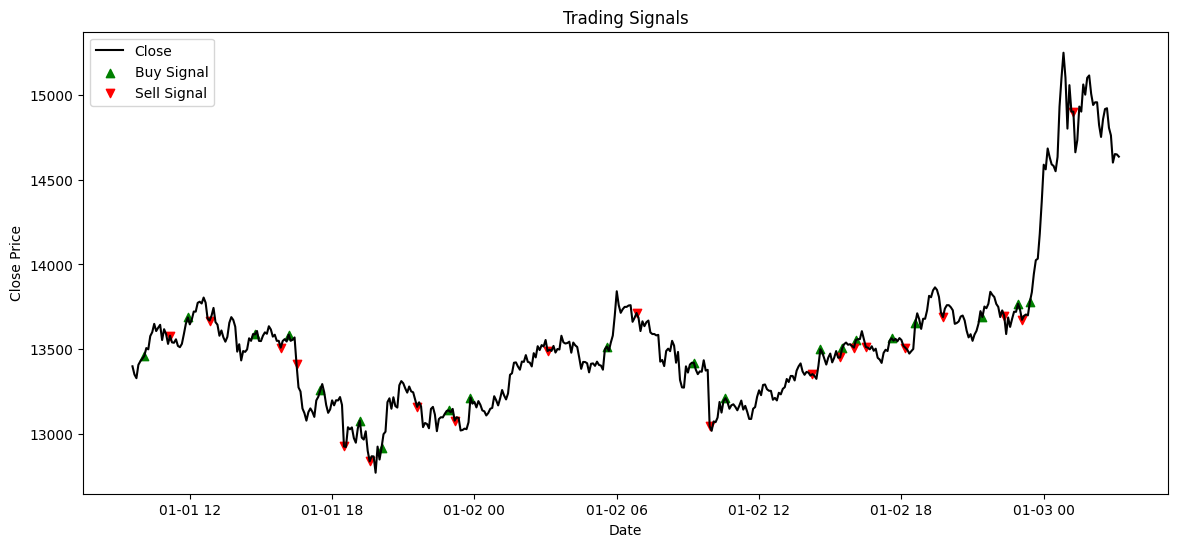

In [44]:
plot_df = test_df.iloc[:500,:]
plt.figure(figsize=(14, 6))

# Plot close values
plt.plot(plot_df.index, plot_df['close'], label='Close', color='black')
# plt.plot(plot_df['SMA_14'],label="14 previous average")
# plt.plot(plot_df['SMA_20'],label="20 previous average")
# plt.plot(plot_df['SMA_50'],label="50 previous average")


# Marking Buy signals with green upward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Buy'].index, plot_df[plot_df['Signal'] == 'Buy']['close'], label='Buy Signal', marker='^', color='g', alpha=1)

# Marking Sell signals with red downward arrows
plt.scatter(plot_df[plot_df['Signal'] == 'Sell'].index, plot_df[plot_df['Signal'] == 'Sell']['close'], label='Sell Signal', marker='v', color='r', alpha=1)

# Marking Wait signals with blue circles
# plt.scatter(plot_df[plot_df['Signal'] == 'Wait'].index, plot_df[plot_df['Signal'] == 'Wait']['close'], label='Wait Signal', marker='o', color='b', alpha=0.5)

plt.title('Trading Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# plot_candlestick_chart(plot_df)